<a href="https://colab.research.google.com/github/FariaParvinMegha/final_work/blob/main/Old_Liking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git

!pip install keras-self-attention

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-vlzxagum
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-vlzxagum
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28111 sha256=02330890c3d3a9e53823b335e3d5344a8e61d1e98e5f6dc22c60fb3f3fb7024c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6k1qgmp8/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg
  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=c14f0cfa0dedb558b1486cfd07ad2618c74b97f5bfcbaeae76097b66148acb3c
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built kera

In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn import svm
import tensorflow as tf
import os
import time
import keras
import keras.backend as K

import tensorflow as tf
from tensorflow import keras
from keras.metrics import Precision, Recall
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv1D
from keras.models import Model
from keras.utils import plot_model

import timeit
from keras.layers import MaxPooling1D, ZeroPadding1D
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras_self_attention import SeqSelfAttention
from keras.layers import (Input, Embedding, Conv1D, Activation, GlobalMaxPooling1D, BatchNormalization,
                          Concatenate, LSTM, Flatten, Dropout, Dense)

In [ ]:
channel = [1,2,4,5,8,10,15,21,22,25,26,27,28,31,32]
band = [4,8,13,22,30,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32']


In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
   meta = []
   with open('/content/drive/MyDrive/data_preprocessed_python/s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;
            #data.shape

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))
                start = start + step_size

        meta = np.array(meta)
        np.save('/content/drive/MyDrive/processed_data/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

<ipython-input-5-f187518c58b2>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  meta.append(np.array(meta_array))


In [ ]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [ ]:
# from sklearn.utils import shuffle
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:
  with open('/content/drive/MyDrive/processed_data/s' + subjects + '.npy', 'rb') as file:

      sub = np.load(file)
      for i in range (0,sub.shape[0]):
        if i % 8 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])




np.save('/content/drive/MyDrive/data_training/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/label_training/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/MyDrive/data_testing/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/label_testing/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (546560, 75) (546560, 4)
testing dataset: (78080, 75) (78080, 4)


In [ ]:
np.load = np_load_old

In [ ]:
import keras
import keras.backend as K
from keras.layers import Conv1D, MaxPooling1D, ZeroPadding1D
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.optimizers import SGD
import timeit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

FOR LIKING

In [ ]:
with open('/content/drive/MyDrive/data_training/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open('/content/drive/MyDrive/label_training/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)


X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Dominance_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

for i in range(len(Z)):
  if Z[i] == 9:
    Z[i] = 8.99

In [ ]:
A=np.copy(Z)

np.unique(Z)

array([1.  , 1.01, 1.03, 1.04, 1.05, 1.06, 1.09, 1.1 , 1.12, 1.15, 1.18,
       1.22, 1.24, 1.26, 1.33, 1.37, 1.42, 1.44, 1.5 , 1.55, 1.73, 1.77,
       1.79, 1.82, 1.83, 1.85, 1.86, 1.87, 1.88, 1.9 , 1.91, 1.92, 1.94,
       1.95, 1.96, 1.97, 1.99, 2.  , 2.01, 2.03, 2.04, 2.05, 2.06, 2.08,
       2.09, 2.1 , 2.12, 2.13, 2.15, 2.18, 2.23, 2.24, 2.26, 2.28, 2.33,
       2.35, 2.36, 2.4 , 2.47, 2.53, 2.54, 2.58, 2.62, 2.73, 2.74, 2.76,
       2.78, 2.79, 2.81, 2.82, 2.86, 2.87, 2.88, 2.9 , 2.91, 2.92, 2.94,
       2.95, 2.96, 2.97, 2.99, 3.  , 3.01, 3.03, 3.04, 3.05, 3.06, 3.08,
       3.12, 3.13, 3.15, 3.17, 3.18, 3.22, 3.23, 3.27, 3.29, 3.35, 3.37,
       3.4 , 3.47, 3.49, 3.51, 3.54, 3.55, 3.58, 3.67, 3.69, 3.71, 3.73,
       3.74, 3.77, 3.78, 3.81, 3.83, 3.86, 3.87, 3.88, 3.9 , 3.92, 3.94,
       3.95, 3.96, 3.97, 3.99, 4.  , 4.01, 4.03, 4.04, 4.05, 4.06, 4.08,
       4.09, 4.1 , 4.12, 4.13, 4.14, 4.19, 4.21, 4.22, 4.29, 4.31, 4.36,
       4.42, 4.45, 4.46, 4.51, 4.55, 4.59, 4.62, 4.

In [ ]:
# liking classes
negative = 0
neutral = 0
positive = 0
for i in range(len(A)):
  if A[i] >= 1 and A[i]<=2.99:
    A [i] = 1
    negative = negative + 1
  if A[i] >= 3 and A[i]<=5.99:
    A [i] = 2
    neutral = neutral + 1
  if A[i] >= 6 and A[i]<=8.99:
    A [i] = 3
    positive = positive + 1

print(negative,neutral, positive)

93310 130802 275600


In [ ]:
x_train = np.array(X[:])

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(A)
y_train = y_train[:,1:]
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
with open('/content/drive/MyDrive/data_validation/data_validation.npy', 'rb') as fileTrain:
    P  = np.load(fileTrain)

with open('/content/drive/MyDrive/label_validation/label_validation.npy', 'rb') as fileTrainL:
    Q  = np.load(fileTrainL)

P = normalize(P)
R = np.ravel(Q[:, [3]])

Arousal_val = np.ravel(Q[:, [0]])
Valence_val = np.ravel(Q[:, [1]])
Domain_val = np.ravel(Q[:, [2]])
Like_val = np.ravel(Q[:, [3]])

for i in range(len(R)):
  if R[i] == 9:
    R[i] = 8.99

In [ ]:
B=np.copy(R)

np.unique(R)

array([1.  , 1.01, 1.03, 1.04, 1.05, 1.06, 1.09, 1.1 , 1.12, 1.15, 1.18,
       1.22, 1.24, 1.26, 1.33, 1.37, 1.42, 1.44, 1.5 , 1.55, 1.73, 1.77,
       1.79, 1.82, 1.83, 1.85, 1.86, 1.87, 1.88, 1.9 , 1.91, 1.92, 1.94,
       1.95, 1.96, 1.97, 1.99, 2.  , 2.01, 2.03, 2.04, 2.05, 2.06, 2.08,
       2.09, 2.1 , 2.12, 2.13, 2.15, 2.18, 2.23, 2.24, 2.26, 2.28, 2.33,
       2.35, 2.36, 2.4 , 2.47, 2.53, 2.54, 2.58, 2.62, 2.73, 2.74, 2.76,
       2.78, 2.79, 2.81, 2.82, 2.86, 2.87, 2.88, 2.9 , 2.91, 2.92, 2.94,
       2.95, 2.96, 2.97, 2.99, 3.  , 3.01, 3.03, 3.04, 3.05, 3.06, 3.08,
       3.12, 3.13, 3.15, 3.17, 3.18, 3.22, 3.23, 3.27, 3.29, 3.35, 3.37,
       3.4 , 3.47, 3.49, 3.51, 3.54, 3.55, 3.58, 3.67, 3.69, 3.71, 3.73,
       3.74, 3.77, 3.78, 3.81, 3.83, 3.86, 3.87, 3.88, 3.9 , 3.92, 3.94,
       3.95, 3.96, 3.97, 3.99, 4.  , 4.01, 4.03, 4.04, 4.05, 4.06, 4.08,
       4.09, 4.1 , 4.12, 4.13, 4.14, 4.19, 4.21, 4.22, 4.29, 4.31, 4.36,
       4.42, 4.45, 4.46, 4.51, 4.55, 4.59, 4.62, 4.

In [ ]:
# liking_val classes
negative_val = 0
neutral_val = 0
positive_val = 0
for i in range(len(B)):
  if B[i] >= 1 and B[i]<=2.99:
    B [i] = 1
    negative_val = negative_val + 1
  if B[i] >= 3 and B[i]<=5.99:
    B [i] = 2
    neutral_val = neutral_val + 1
  if B[i] >= 6 and B[i]<=8.99:
    B [i] = 3
    positive_val = positive_val + 1

print(negative_val,neutral_val, positive_val)

11661 16339 34464


In [ ]:
x_val = np.array(P[:])

In [ ]:
from keras.utils import to_categorical
y_val = to_categorical(B)
y_val = y_val[:,1:]
y_val

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
with open('/content/drive/MyDrive/data_testing/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open('/content/drive/MyDrive/label_testing/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

for i in range(len(L)):
  if L[i] == 9:
    L[i] = 8.99

In [ ]:
C=np.copy(L)

np.unique(L)

array([1.  , 1.01, 1.03, 1.04, 1.05, 1.06, 1.09, 1.1 , 1.12, 1.15, 1.18,
       1.22, 1.24, 1.26, 1.33, 1.37, 1.42, 1.44, 1.5 , 1.55, 1.73, 1.77,
       1.79, 1.82, 1.83, 1.85, 1.86, 1.87, 1.88, 1.9 , 1.91, 1.92, 1.94,
       1.95, 1.96, 1.97, 1.99, 2.  , 2.01, 2.03, 2.04, 2.05, 2.06, 2.08,
       2.09, 2.1 , 2.12, 2.13, 2.15, 2.18, 2.23, 2.24, 2.26, 2.28, 2.33,
       2.35, 2.36, 2.4 , 2.47, 2.53, 2.54, 2.58, 2.62, 2.73, 2.74, 2.76,
       2.78, 2.79, 2.81, 2.82, 2.86, 2.87, 2.88, 2.9 , 2.91, 2.92, 2.94,
       2.95, 2.96, 2.97, 2.99, 3.  , 3.01, 3.03, 3.04, 3.05, 3.06, 3.08,
       3.12, 3.13, 3.15, 3.17, 3.18, 3.22, 3.23, 3.27, 3.29, 3.35, 3.37,
       3.4 , 3.47, 3.49, 3.51, 3.54, 3.55, 3.58, 3.67, 3.69, 3.71, 3.73,
       3.74, 3.77, 3.78, 3.81, 3.83, 3.86, 3.87, 3.88, 3.9 , 3.92, 3.94,
       3.95, 3.96, 3.97, 3.99, 4.  , 4.01, 4.03, 4.04, 4.05, 4.06, 4.08,
       4.09, 4.1 , 4.12, 4.13, 4.14, 4.19, 4.21, 4.22, 4.29, 4.31, 4.36,
       4.42, 4.45, 4.46, 4.51, 4.55, 4.59, 4.62, 4.

In [ ]:
# liking_test classes
negative_test = 0
neutral_test = 0
positive_test = 0
for i in range(len(C)):
  if C[i] >= 1 and C[i]<=2.99:
    C [i] = 1
    negative_test = negative_test + 1
  if C[i] >= 3 and C[i]<=5.99:
    C [i] = 2
    neutral_test = neutral_test + 1
  if C[i] >= 6 and C[i]<=8.99:
    C [i] = 3
    positive_test = positive_test + 1

print(negative_test,neutral_test, positive_test)

11661 16339 34464


In [ ]:
x_test = np.array(M[:])

In [ ]:
from keras.utils import to_categorical
y_test = to_categorical(C)
y_test = y_test[:,1:]
y_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(499712, 3)
(62464, 3)
(62464, 3)


In [ ]:
batch_size = 256
num_classes = 3
epochs = 10
input_shape=(x_train.shape[1], 1)

In [ ]:
print(input_shape)

(75, 1)


In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight=sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight=sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

For Liking

Model CNN

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense,GRU,SpatialDropout1D,Bidirectional
from keras.regularizers import l2

In [ ]:
modelA = Sequential()

intput_shape=(x_train.shape[1], 1)

modelA.add(Conv1D(1024, kernel_size=9,padding = 'same',activation='relu', input_shape=input_shape))
modelA.add(BatchNormalization())
modelA.add(MaxPooling1D(pool_size=(2)))

modelA.add(Conv1D(512,kernel_size=6,padding = 'same', activation='relu'))
modelA.add(BatchNormalization())
modelA.add(MaxPooling1D(pool_size=(2)))

modelA.add(Conv1D(256,kernel_size=6,padding = 'same', activation='relu'))
modelA.add(BatchNormalization())
modelA.add(MaxPooling1D(pool_size=(2)))

modelA.add(Conv1D(128,kernel_size=6,padding = 'same', activation='relu'))
modelA.add(BatchNormalization())
modelA.add(MaxPooling1D(pool_size=(2)))

modelA.add(Flatten())

modelA.add(Dense(1024, activation='relu'))
modelA.add(Dropout(0.2))

modelA.add(Dense(256, activation='relu'))
modelA.add(Dropout(0.2))

modelA.add(Dense(64, activation='relu'))
modelA.add(Dropout(0.2))

modelA.add(Dense(num_classesA, activation='softmax'))
modelA.summary()

Model CNN+BiLSTM

In [ ]:
model_HB = Sequential()

intput_shape=(x_train.shape[1], 1)

model_HB.add(Conv1D(1024, kernel_size=9,padding = 'same',activation='relu', input_shape=input_shape))
model_HB.add(BatchNormalization())
model_HB.add(MaxPooling1D(pool_size=(2)))

model_HB.add(Conv1D(512,kernel_size=6,padding = 'same', activation='relu'))
model_HB.add(BatchNormalization())
model_HB.add(MaxPooling1D(pool_size=(2)))

model_HB.add(Conv1D(256,kernel_size=6,padding = 'same', activation='relu'))
model_HB.add(BatchNormalization())
model_HB.add(MaxPooling1D(pool_size=(2)))

model_HB.add(Conv1D(128,kernel_size=6,padding = 'same', activation='relu'))
model_HB.add(BatchNormalization())
model_HB.add(MaxPooling1D(pool_size=(2)))


model_HB.add(LSTM(units=64,return_sequences=True))
model_HB.add(SeqSelfAttention(attention_activation='tanh'))
model_HB.add(Dropout(0.2))

model_HB.add(LSTM(units=128,return_sequences=True))
model_HB.add(SeqSelfAttention(attention_activation='tanh'))
model_HB.add(Dropout(0.2))

model_HB.add(LSTM(units=128,return_sequences=True))
model_HB.add(SeqSelfAttention(attention_activation='tanh'))
model_HB.add(Dropout(0.2))

model_HB.add(LSTM(units=256,return_sequences=True))
model_HB.add(SeqSelfAttention(attention_activation='tanh'))

model_HB.add(Flatten())

model_HB.add(Dense(1024, activation='relu'))
model_HB.add(Dropout(0.2))

model_HB.add(Dense(256, activation='relu'))
model_HB.add(Dropout(0.2))

model_HB.add(Dense(64, activation='relu'))
model_HB.add(Dropout(0.2))

model_HB.add(Dense(num_classes, activation='softmax'))

model_HB.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 75, 1024)          10240     
                                                                 
 batch_normalization (Batch  (None, 75, 1024)          4096      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 37, 1024)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 512)           3146240   
                                                                 
 batch_normalization_1 (Bat  (None, 37, 512)           2048      
 chNormalization)                                                
                                                        

In [ ]:
model_HB.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy', Precision(), F1Score()]
)

In [ ]:
model_name = "FHybrid_model"
directory_path = "/content/drive/MyDrive/Thesis"
weights_filename = "weights-improvement_" + model_name + ".hdf5"
os.makedirs(directory_path, exist_ok=True)

# Complete file path for the model weights
filepath_CLB = os.path.join(directory_path, weights_filename)
print("Model weights will be saved to:", filepath_CLB)

checkpoint = ModelCheckpoint(filepath_CLB, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.2, patience=2, min_lr=0.001, verbose=1)

# Combine all callbacks in a list
callbacks_list = [es, checkpoint, reduce_lr]

Model weights will be saved to: /content/drive/MyDrive/Thesis/weights-improvement_FHybrid_model.hdf5


In [ ]:
FHybridmodel = model_HB.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val),
          callbacks= callbacks_list)

Epoch 1/10
1952/1952 [==============================] - ETA: 0s - loss: 0.8268 - accuracy: 0.6054 - precision: 0.6582 - f1_score: 0.5617
Epoch 1: val_accuracy improved from -inf to 0.65409, saving model to /content/drive/MyDrive/Thesis/weights-improvement_FHybrid_model.hdf5
1952/1952 [==============================] - 203s 91ms/step - loss: 0.8268 - accuracy: 0.6054 - precision: 0.6582 - f1_score: 0.5617 - val_loss: 0.7420 - val_accuracy: 0.6541 - val_precision: 0.6901 - val_f1_score: 0.6382 - lr: 0.0010
Epoch 2/10
1952/1952 [==============================] - ETA: 0s - loss: 0.6823 - accuracy: 0.6863 - precision: 0.7310 - f1_score: 0.6682
Epoch 2: val_accuracy improved from 0.65409 to 0.71233, saving model to /content/drive/MyDrive/Thesis/weights-improvement_FHybrid_model.hdf5
1952/1952 [==============================] - 180s 92ms/step - loss: 0.6823 - accuracy: 0.6863 - precision: 0.7310 - f1_score: 0.6682 - val_loss: 0.6294 - val_accuracy: 0.7123 - val_precision: 0.7506 - val_f1_scor

In [ ]:
score_Hybrid = model_HB.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_Hybrid[0])
print('Test accuracy:', score_Hybrid[1])
print('Test precision:', score_Hybrid[2])
print('Test f1_score:', score_Hybrid[3])

1952/1952 [==============================] - 16s 8ms/step - loss: 0.3453 - accuracy: 0.8724 - precision: 0.8812 - f1_score: 0.8726
Test loss: 0.34534940123558044
Test accuracy: 0.8723905086517334
Test precision: 0.8811739087104797
Test f1_score: 0.8726420402526855


VALANCE PLOTS

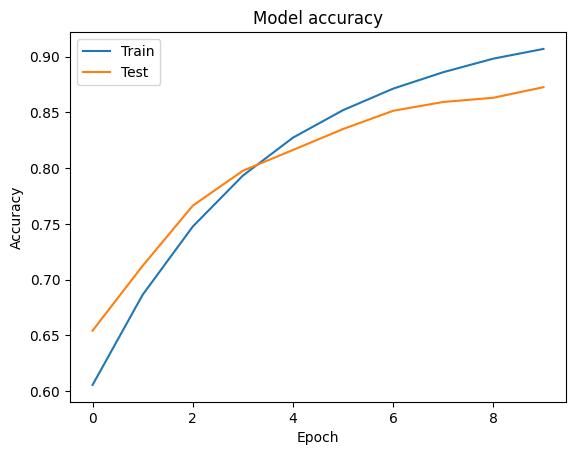

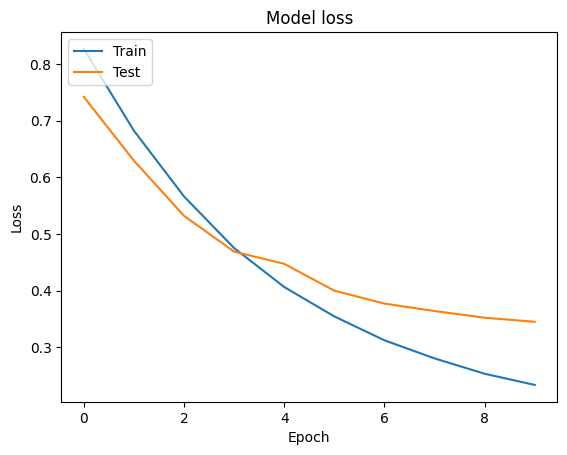

In [ ]:
# Plot training & validation accuracy values
plt.plot(FHybridmodel.history['accuracy'])
plt.plot(FHybridmodel.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(FHybridmodel.history['loss'])
plt.plot(FHybridmodel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1952/1952 [==============================] - 15s 7ms/step


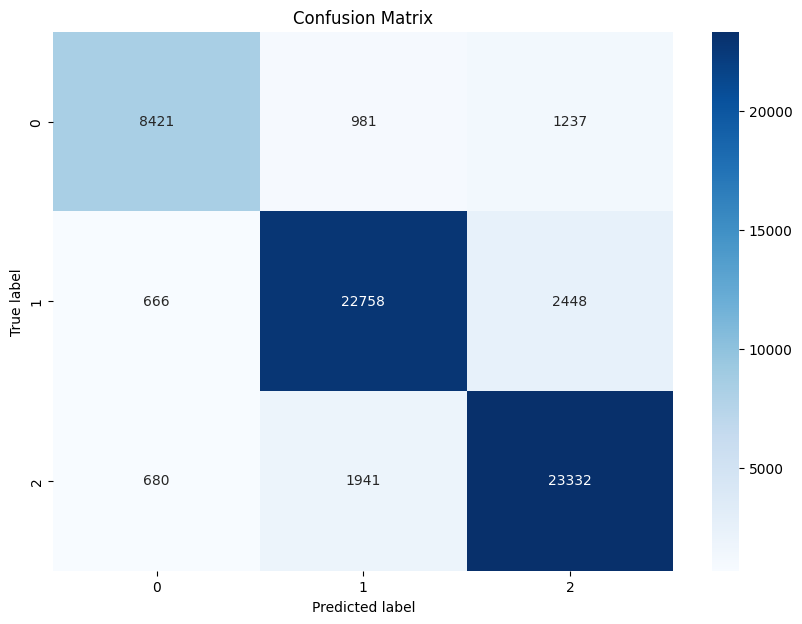

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert one-hot encoded predictions and labels to class indices
y_pred_classes = np.argmax(model_HB.predict(x_val), axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
base_path_model = "/content/drive/MyDrive/Thesis/"
accuracy = "_87"

path_model_HB = base_path_model + model_name + accuracy + ".h5"
model_HB.save(path_model_HB)
print(path_model_HB)

/content/drive/MyDrive/Thesis/FHybrid_model_87.h5


FOR LIKING


In [ ]:
model_name = "FHybrid_model_liking"
directory_path = "/content/drive/MyDrive/Thesis"
weights_filename = "weights-improvement_" + model_name + ".hdf5"
os.makedirs(directory_path, exist_ok=True)

# Complete file path for the model weights
filepath_CLB = os.path.join(directory_path, weights_filename)
print("Model weights will be saved to:", filepath_CLB)

checkpoint = ModelCheckpoint(filepath_CLB, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.2, patience=2, min_lr=0.001, verbose=1)

# Combine all callbacks in a list
callbacks_list = [es, checkpoint, reduce_lr]

Model weights will be saved to: /content/drive/MyDrive/Thesis/weights-improvement_FHybrid_model_liking.hdf5


In [ ]:
FHybridmodel_liking = model_HB.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val),
          callbacks= callbacks_list)

Epoch 1/10
1952/1952 [==============================] - ETA: 0s - loss: 0.8012 - accuracy: 0.6166 - precision: 0.6795 - f1_score: 0.5703
Epoch 1: val_accuracy improved from -inf to 0.65587, saving model to /content/drive/MyDrive/Thesis/weights-improvement_FHybrid_model_liking.hdf5
1952/1952 [==============================] - 207s 94ms/step - loss: 0.8012 - accuracy: 0.6166 - precision: 0.6795 - f1_score: 0.5703 - val_loss: 0.7259 - val_accuracy: 0.6559 - val_precision: 0.7131 - val_f1_score: 0.6252 - lr: 0.0010
Epoch 2/10
1952/1952 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.6920 - precision: 0.7407 - f1_score: 0.6718
Epoch 2: val_accuracy improved from 0.65587 to 0.72059, saving model to /content/drive/MyDrive/Thesis/weights-improvement_FHybrid_model_liking.hdf5
1952/1952 [==============================] - 184s 94ms/step - loss: 0.6661 - accuracy: 0.6920 - precision: 0.7407 - f1_score: 0.6718 - val_loss: 0.6039 - val_accuracy: 0.7206 - val_precision: 0.7654

In [ ]:
score_Hybrid = model_HB.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_Hybrid[0])
print('Test accuracy:', score_Hybrid[1])
print('Test precision:', score_Hybrid[2])
print('Test f1_score:', score_Hybrid[3])

1952/1952 [==============================] - 18s 8ms/step - loss: 0.3233 - accuracy: 0.8764 - precision: 0.8859 - f1_score: 0.8764
Test loss: 0.3232729732990265
Test accuracy: 0.8764408230781555
Test precision: 0.8859301805496216
Test f1_score: 0.8764259219169617


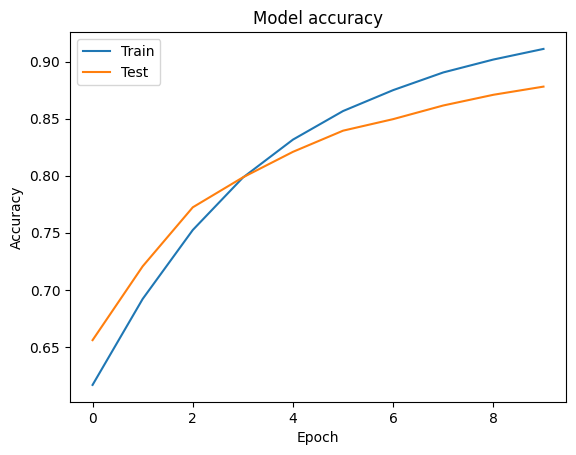

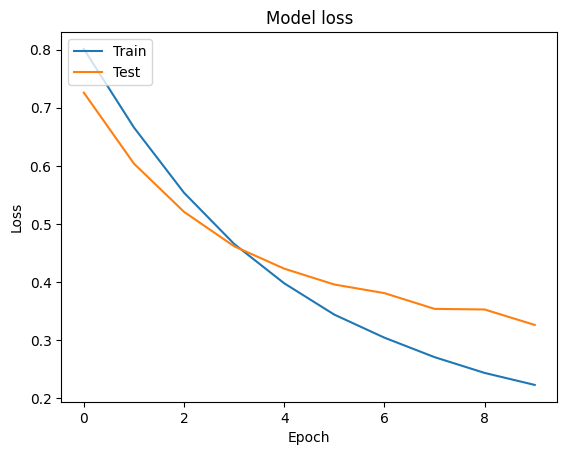

In [ ]:
# Plot training & validation accuracy values
plt.plot(FHybridmodel_liking.history['accuracy'])
plt.plot(FHybridmodel_liking.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(FHybridmodel_liking.history['loss'])
plt.plot(FHybridmodel_liking.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1952/1952 [==============================] - 12s 6ms/step


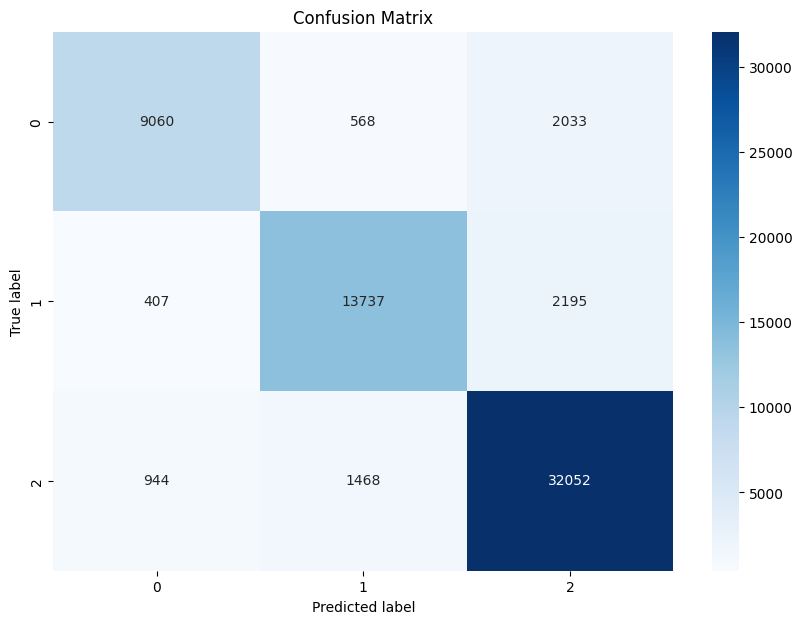

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert one-hot encoded predictions and labels to class indices
y_pred_classes = np.argmax(model_HB.predict(x_val), axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

1952/1952 [==============================] - 12s 6ms/step


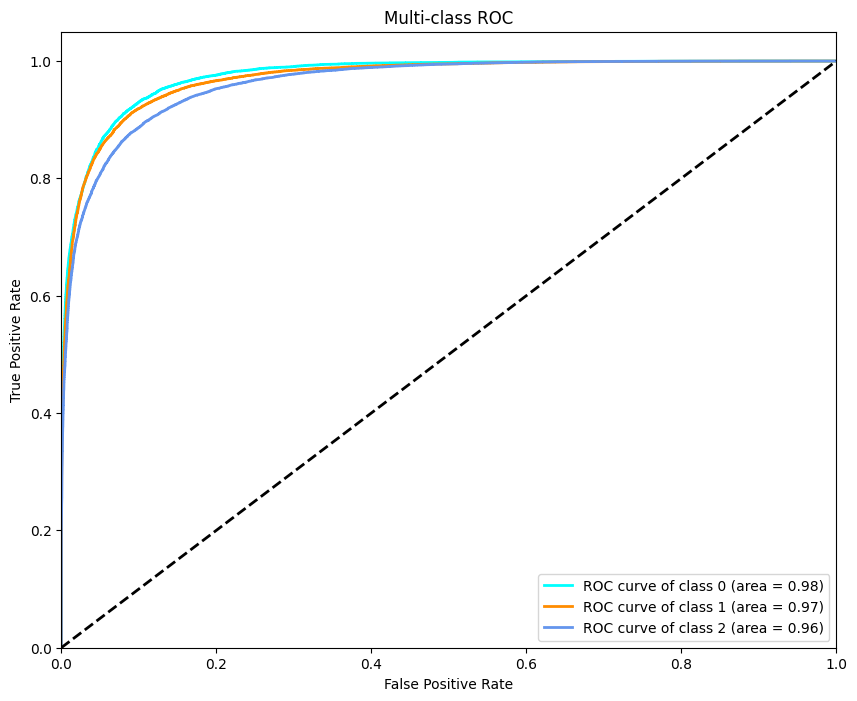

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp

# Assuming `model` is your trained CNN model
# `X_test` is your test data, `y_test` are your true labels (as integers 0, 1, 2 for negative, neutral, positive)

# Binarize the labels for ROC calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Predict probabilities for each class
y_score = model_HB.predict(x_test)  # Ensure this gives you the probability for each class

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


In [ ]:
base_path_model = "/content/drive/MyDrive/Thesis/"
accuracy = "_87"

path_model_HB = base_path_model + model_name + accuracy + ".h5"
model_HB.save(path_model_HB)
print(path_model_HB)

/content/drive/MyDrive/Thesis/FHybrid_model_liking_87.h5
